In [2]:
import numpy as np
import glob
import os

import matplotlib.pyplot as plt

from scripts_fermions.operators import Hamiltonian, Boost
import yastn
from yastn.tn import mps

In [3]:
g = 1
v, Q = 1, 1
N = 256
a = 0.125
m = 0
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/state_t=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fns = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", "dt=0.0625", f"{N=}", f"{v=:0.4f}", f"{Q=:0.4f}", f"{a=:0.4f}", f"{m=:0.4f}"])]);

In [5]:
#
D = 128
#
ops = yastn.operators.SpinlessFermions(sym='U1', tensordot_policy='no_fusion')
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fex = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/gs/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fgs = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*_boosted.npy")
fnames = glob.glob(glob_path, recursive=True)
fbt = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{m=:0.4f}"])])
#
def fn_mass(fns, **kwargs):
    return [x for x in fns if all( f"{k}={v}" in x for k, v in kwargs.items())][0]
#
d_ex = np.load(fn_mass(fex ), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs ), allow_pickle=True).item()
d_boost = np.load(fn_mass(fbt), allow_pickle=True).item()


In [6]:
d_ex = np.load(fn_mass(fex, m=m), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs, m=m), allow_pickle=True).item()
psi_ex = yastn.from_dict(d_ex['psi'])
psi_gs = yastn.from_dict(d_gs['psi'])

H = Hamiltonian(N, m, g, t=0, a=a, v=1, Q=0, ops=ops)
K = Boost(N, m, g, a, ops)

E_ex = mps.vdot(psi_ex, H, psi_ex).real
E_gs = mps.vdot(psi_gs, H, psi_gs).real

In [7]:
Ds = [128, 256, 512]

In [10]:
ts = np.linspace(0, 16, 17)
psi_t = {(t, D): yastn.from_dict(np.load(fn_mass(fns, t=t, D=D), allow_pickle=True).item()['psi']) for t in ts for D in Ds}
chis = [x for x in d_boost['chis'] if x <= 2]
psi_chi = {chi: yastn.from_dict(d_boost['psi'][ii]) for ii, chi in enumerate(chis)}

In [15]:
probs = {}
for (t, D), pt in psi_t.items():
    print(t, D)
    for chi, pc in psi_chi.items():
        if (t, D, chi) not in probs:
            probs[t, D, chi] = np.abs(mps.vdot(pt, pc)) ** 2


0.0 128
0.0 256
0.0 512
1.0 128
1.0 256
1.0 512
2.0 128
2.0 256
2.0 512
3.0 128
3.0 256
3.0 512
4.0 128
4.0 256
4.0 512
5.0 128
5.0 256
5.0 512
6.0 128
6.0 256
6.0 512
7.0 128
7.0 256
7.0 512
8.0 128
8.0 256
8.0 512
9.0 128
9.0 256
9.0 512
10.0 128
10.0 256
10.0 512
11.0 128
11.0 256
11.0 512
12.0 128
12.0 256
12.0 512
13.0 128
13.0 256
13.0 512
14.0 128
14.0 256
14.0 512
15.0 128
15.0 256
15.0 512
16.0 128
16.0 256
16.0 512


In [16]:
np.save(f"./results_fermions/probs_{m=}_{N=}_{a=}.npy", probs, allow_pickle=True)
probs = np.load(f"./results_fermions/probs_{m=}_{N=}_{a=}.npy", allow_pickle=True).item()

In [11]:
probs_gs = {(t, D): np.abs(mps.vdot(pt, psi_gs)) ** 2 for (t, D), pt in psi_t.items()}

In [17]:
np.save(f"./results_fermions/probs_gs_{m=}_{N=}_{a=}.npy", probs_gs, allow_pickle=True)
probs_gs = np.load(f"./results_fermions/probs_gs_{m=}_{N=}_{a=}.npy", allow_pickle=True).item()


Text(0.5, 1.0, 'N=256  a=0.125')

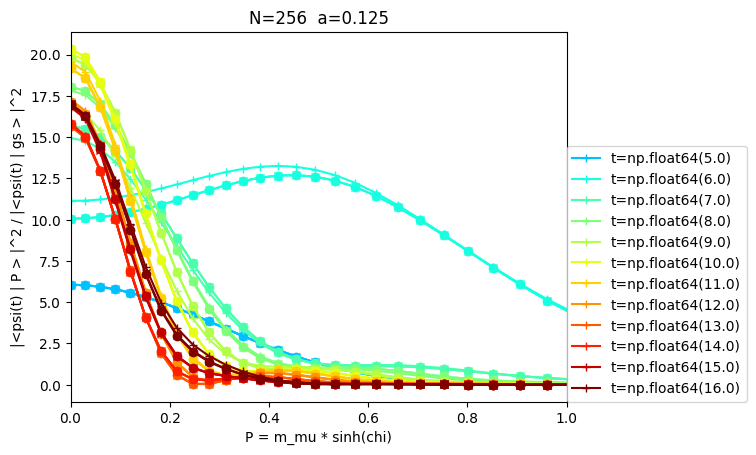

In [21]:
cm = plt.cm.jet
syms = dict(zip(Ds, ['+-', 'x-', 'o-']))
for t in ts[5:]:
  for D in Ds:
    pr = [probs[t, D, chi] / probs_gs[t, D] for chi in chis]
    P = np.sinh(chis) * (E_ex - E_gs)
    line, = plt.plot(P, pr, syms[D], color = cm(t / ts[-1]))
    if D == Ds[0]:
      line.set_label(f"{t=}")

plt.xlabel('P = m_mu * sinh(chi)')
plt.ylabel("|<psi(t) | P > |^2 / |<psi(t) | gs > |^2")
plt.legend(loc=(1, 0))
plt.xlim([0, 1])
plt.title(f"{N=}  {a=}")
#plt.ylim([1e-4, 1e2])

Text(0.5, 1.0, 'N=256  a=0.125')

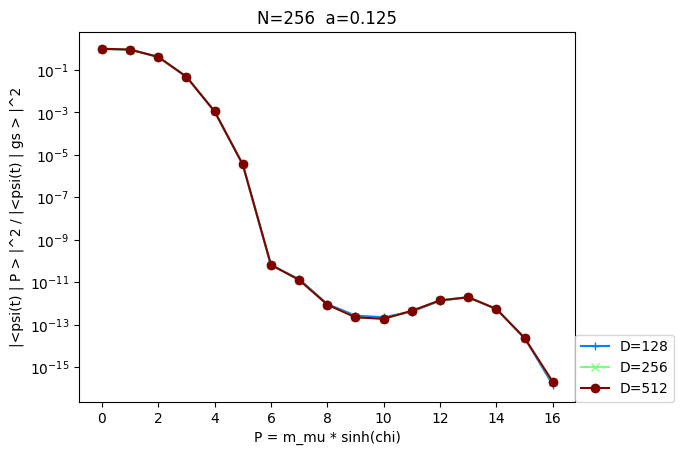

In [22]:
cm = plt.cm.jet
syms = dict(zip(Ds, ['+-', 'x-', 'o-']))
for D in Ds:
    pr = [probs_gs[t, D] for t in ts]
    line, = plt.semilogy(ts, pr, syms[D], color = cm(D / Ds[-1]))
    line.set_label(f"{D=}")

plt.xlabel('P = m_mu * sinh(chi)')
plt.ylabel("|<psi(t) | P > |^2 / |<psi(t) | gs > |^2")
plt.legend(loc=(1, 0))
plt.title(f"{N=}  {a=}")
#plt.ylim([1e-4, 1e2])

In [67]:
def trace_norm(psi0, psi1, Nc = 64):
    N = psi0.N
    N2 = N // 2
    s0 = N2 - Nc // 2
    s1 = N2 + Nc // 2


    psi0 = psi0.shallow_copy()
    psi1 = psi1.shallow_copy()

    for n in range(0, N2):
        psi0.orthogonalize_site_(n=n, to='last', normalize=True)
        psi0.absorb_central_(to='last')
        psi1.orthogonalize_site_(n=n, to='last', normalize=True)
        psi1.absorb_central_(to='last')

    for n in range(N-1, N2, -1):
        psi0.orthogonalize_site_(n=n, to='first', normalize=True)
        psi0.absorb_central_(to='first')
        psi1.orthogonalize_site_(n=n, to='first', normalize=True)
        psi1.absorb_central_(to='first')

    tmp = yastn.ncon([psi0[s0], psi1[s0].conj()], [[-0, 1, -2], [-1, 1, -3]])
    for n in range(s0+1, s1):
        tmp = yastn.ncon([tmp, psi0[n], psi1[n].conj()], [[-0, -1, 1, 3], [1, 2, -2], [3, 2, -3]])
    return np.abs(yastn.vdot(tmp, tmp).item())


In [68]:
x = trace_norm(psi_t[10], psi_chi[0], Nc = 32)